In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
sys.path.append("../..")
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union
from multiscale_sde.util import softplus_inverse

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim

import torchsde
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

manual_seed(0)
plt.style.use('seaborn-poster')
import seaborn as sns 

/home/hbz15/vector/torchsde/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1290232/469636018.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


In [3]:
# ts = np.concatenate(
#     [
#         np.random.uniform(low=0.1, high=0.5, size=5),
#         np.random.uniform(low=1.5, high=1.9, size=5)
#     ],
#     axis=0
# )
ts = np.linspace(0., 2., 100)
ts = np.sort(ts)
ts = torch.Tensor(ts).to(device)

In [4]:
method = "euler"
dt = 1e-3
adaptive = False
rtol = 1e-3
atol = 1e-3
adjoint = False
kl_anneal_iters = 100
dpi = 300
batch_size=512
sdeint_fn = torchsde.sdeint


In [5]:
class AgeHeartSDE(torchsde.SDEIto):

    def __init__(self, period=0.2, device="cpu"):
        super().__init__(noise_type="diagonal")
        self.device = device
        # let's do t\in [0, 2]
        self.period = period
        self.y0_mean = torch.Tensor([0, 0]).to(device) 
        self.y0_std = torch.Tensor([1, 1]).to(device) 
        

    def f(self, t, y):  # drift
        y_1 = y[:,:1]
        drift_1 = torch.ones(y_1.size(), device=self.device)
        drift_2 = y_1*20*torch.cos(2*np.pi * t / self.period)
        drift = torch.cat([drift_1, drift_2], axis=1)
        return drift
    
    def g(self, t, y):  # Diffusion.
        return torch.ones(y.size(), device=self.device)*math.sqrt(2)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.y0_std) if eps is None else eps
        y0 = self.y0_mean + eps * self.y0_std
        ys = sdeint_fn(
            sde=self,
            y0=y0,
            ts=ts,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            names={'drift': 'f', 'diffusion': 'g'}
        )
        return ys

In [6]:
dataSDE = AgeHeartSDE(period=0.2, device=device)

In [7]:
# sample some points from this multiscale system
y = dataSDE.forward(ts[:,None], batch_size=5)

In [8]:
y_plot = y.cpu().detach().numpy()
ts_plot = ts.detach().cpu().numpy()

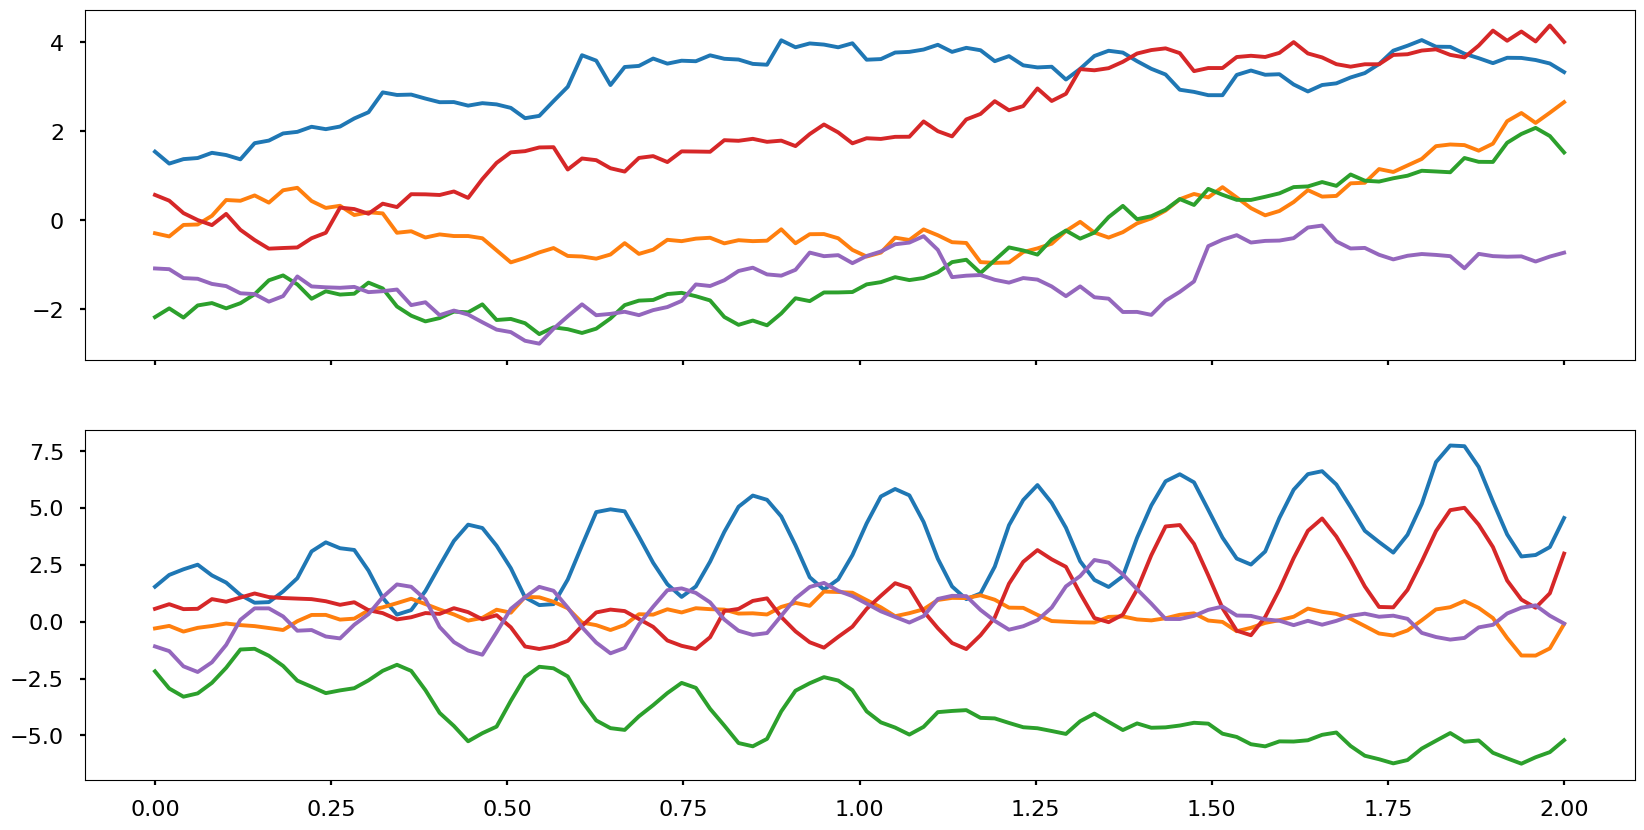

In [9]:
fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)
ax1.plot(ts_plot, y_plot[:,:,0])
ax2.plot(ts_plot, y_plot[:,:,1])
plt.savefig("data.pdf")

## 

In [10]:
y.shape

torch.Size([100, 5, 2])

In [11]:
## select training data
ts_train = ts[:, None]
y_train = y[:,0,:]


In [12]:
y_train.size(), ts_train.size()

(torch.Size([100, 2]), torch.Size([100, 1]))

## Latent SDE

In [13]:
torch.tensor([[1., 1.]]).shape

torch.Size([1, 2])

In [83]:
# pick SDEInt
sdeint_fn = torchsde.sdeint

# pick model hyperparameters
method = "euler"
dt = 1e-3
adaptive = False 
rtol = 1e-3
atol = 1e-3

class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val

def _stable_division(a, b, epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon) * b.sign())
    return a / b

class LatentSDE(torchsde.SDEIto):

    def __init__(self, device="cpu"):
        super(LatentSDE, self).__init__(noise_type="diagonal")

        self.device = device

        # Approximate posterior drifts
        self.net1 = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        self.net2 = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # Prior drifts
        self.prior_net1 = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        self.prior_net2 = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

        # set prior and posterior initial conditions
        self.register_buffer("py0_mean", torch.zeros((2)))
        self.register_buffer("py0_std", torch.ones((2)))
        self.qy0_mean = nn.Parameter(torch.tensor([0., 0.]), requires_grad=True)
        self.qy0_std_unconstrained = nn.Parameter(torch.tensor([1., 1.]), requires_grad=True)
    @property
    def qy0_std(self):
        return nn.functional.softplus(self.qy0_std_unconstrained)

    def f(self, t, y):  # Approximate posterior drift.
        drift1 = self.net1(y[:,:1])
        drift2 = self.net2(y)
        drift = torch.cat([drift1, drift2], axis=1)
        return drift

    def f_prior(self, t, y):  # Prior drift.
        drift1 = self.prior_net1(y[:,:1])
        drift2 = self.prior_net2(y)
        drift = torch.cat([drift1, drift2], axis=1)
        return drift
    
    def g(self, t, y):  # Shared diffusion.
        """
        """
        # return self.sigma.repeat(y.size(0), 1)
        # drift matrix = sigma^2 * sqrt(2 / l) for Matern12 kernel (diffusion of BM is 2/l)
        return torch.ones(y.size(), device=self.device) * math.sqrt(2)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:,:-1]
        f, g, f_prior = self.f(t, y), self.g(t, y), self.f_prior(t, y)
        u = _stable_division(f - f_prior, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:,:2]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y[:,:1])
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0) # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=method,
            dt=dt,
            adaptive=adaptive,
            rtol=rtol,
            atol=atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, :2], aug_ys[-1, :, -1]
        logqp = logqp0.sum() + logqp_path.mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt, names={'drift': 'f_prior'})
        return yt

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        yt = sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=dt, names={"drift" : "f"})
        return yt

In [84]:
model = LatentSDE(device=device).to(device)
# test forward
y_forward, kl = model.forward(ts_train, batch_size=5)
print(y_forward.shape, kl)

torch.Size([100, 5, 2]) tensor(0.6912, device='cuda:0', grad_fn=<AddBackward0>)


In [71]:
ts_train.shape, y_train.shape

(torch.Size([100, 1]), torch.Size([100, 2]))

In [33]:
# test sample_p
print(model.f_prior(ts_train, y_train).shape, model.g(ts_train, y_train).shape)
print(model.sample_p(ts_train, batch_size=5).shape)

torch.Size([100, 2]) torch.Size([100, 2])
torch.Size([100, 5, 2])


In [34]:
# test sample_q
print(model.f(ts_train, y_train).shape, model.g(ts_train, y_train).shape)
print(model.sample_q(ts_train, batch_size=5).shape)

torch.Size([100, 2]) torch.Size([100, 2])
torch.Size([100, 5, 2])


In [85]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
kl_scheduler = LinearScheduler(iters=100)

In [112]:
for global_step in tqdm.tqdm(range(300)):
        optimizer.zero_grad()
        zs, kl = model(ts=ts_train, batch_size=128)
        zs = zs.squeeze()
        # zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.
        likelihood_constructor = distributions.Normal
        likelihood = likelihood_constructor(loc=zs, scale=0.01)
        logpy = likelihood.log_prob(y_train[:,None,:]).sum(dim=[0,-1]).mean(dim=0)
        loss = -logpy + kl * kl_scheduler.val
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

  0%|          | 1/300 [00:15<1:15:13, 15.09s/it]


KeyboardInterrupt: 

## Check predictions

In [98]:
y_pred_plot[:,:,0] = np.sort(y_pred_plot[:,:,0], axis=1).shape
y_pred_plot[:,:,1] = np.sort(y_pred_plot[:,:,1], axis=1).shape

(100, 32)

In [106]:
y_pred_plot_bottom.shape

(100, 32)

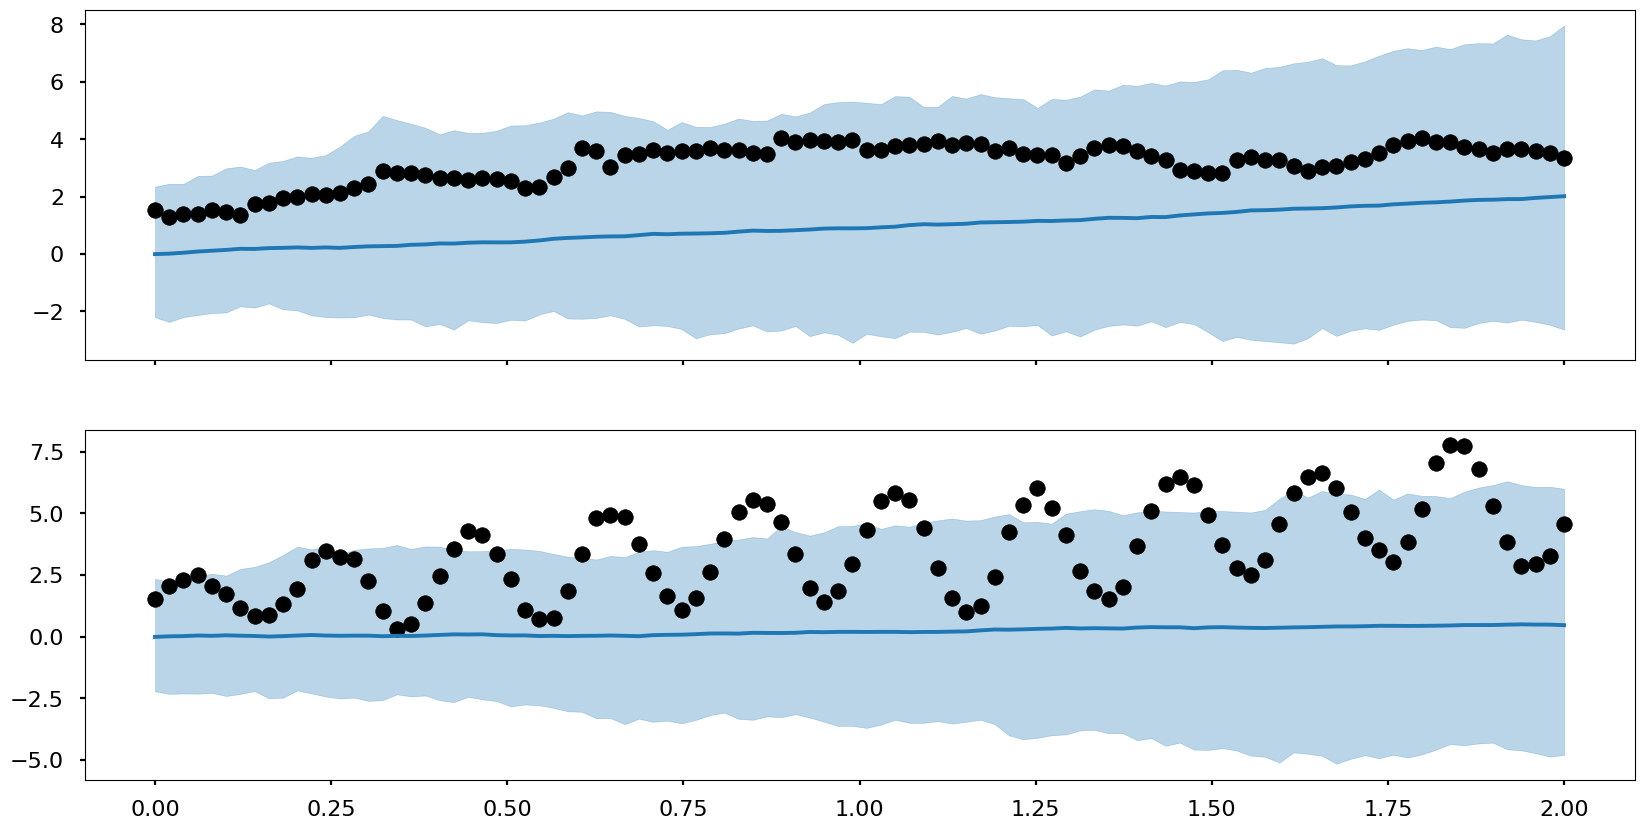

In [115]:
y_pred_plot = zs.cpu().detach().numpy()
y_pred = zs.mean(1).cpu().detach().numpy()
fig, (ax1, ax2) = plt.subplots(2, frameon=False, figsize=(20,10), sharex=True)
ax1.plot(ts_plot, y_pred[:,0], color="C0")
ax2.plot(ts_plot, y_pred[:,1], color="C0")

# plot the credible interval
y_pred_plot[:,:,0] = np.sort(y_pred_plot[:,:,0], axis=1)
y_pred_plot[:,:,1] = np.sort(y_pred_plot[:,:,1], axis=1)
percentile = 0.95
idx = int((1 - percentile) / 2. * y_pred_plot.shape[1])
y_pred_plot_bottom, y_pred_plot_top = y_pred_plot[:, idx,0], y_pred_plot[:, -idx,0]
ax1.fill_between(ts_plot, y_pred_plot_bottom, y_pred_plot_top, alpha=0.3, color="C0")

y_pred_plot_bottom, y_pred_plot_top = y_pred_plot[:, idx,1], y_pred_plot[:, -idx,1]
ax2.fill_between(ts_plot, y_pred_plot_bottom, y_pred_plot_top, alpha=0.3, color="C0")

ax1.scatter(ts_plot, y_plot[:,0,0], color="black")
ax2.scatter(ts_plot, y_plot[:,0,1], color="black")
plt.savefig("data.pdf")